# Treść zadania

Celem ćwiczenia jest zapoznanie z jednym z klasycznych problemów teorii współbieżności -
problemem pięciu filozofów (autor E.W. Dijkstra).

1. Zaimplementować trywialne rozwiązanie z symetrycznymi filozofami. Zaobserwować problem blokady
2. Zaimplementować rozwiązanie z widelcami podnoszonymi jednocześnie. Jaki problem może tutaj wystąpić?
3. Zaimplementować rozwiązanie z lokajem
4. Wykonać pomiary dla każdego rozwiązania i wywnioskować co ma wpływ na wydajność każdego rozwiązania

Dodatkowe zadanie: Zaproponować autorskie rozwiązanie, inne niż w/w.

# Rozwiązania

Problem pięciu filozofów można opisać następująco:

- Każdy filozof zajmuje się głównie myśleniem
- Od czasu do czasu potrzebuje zjeść
- Do jedzenia potrzebne mu są oba widelce po jego prawej i lewej stronie
- Jedzenie trwa skończoną (ale nieokreśloną z góry) ilość czasu, po czym filozof widelce odkłada i wraca do myślenia
- Cykl powtarza się od początku

W trakcie wykonania tego laboratorium powstała następująca struktura:

```
tw-lab5/src/main/java/pl/edu/agh/tw/knapp/lab5
    Arbiter.java
    Fork.java
    Logger.java
    Main.java
    naive
        AdvancedNaiveArbiter.java
        ForkAcquireException.java
        NaiveArbiter.java
    Philosopher.java
    RandomSleeper.java
    simultaneous
        ForkPool.java
    Table.java
    waiter
        Pair.java
        Waiter.java
```

Poniżej zostaną omówione poszczególne klasy i rozwiązania (4 = 3 + **1** – wraz z dodatkowym).

## Wspólne klasy

W tym rozdziale omówię klasy, wspólne dla wszystkich **czterech** rozwiązań.

### `Fork`

Jest to klasa reprezentująca widelec. Zawiera semafor o wartości początkowej 1 oraz
inne pomocnicze funkcje.

```java
// Fork.java

package pl.edu.agh.tw.knapp.lab5;

import java.util.concurrent.Semaphore;
import java.util.concurrent.TimeUnit;

public class Fork {
    private final Semaphore semaphore = new Semaphore(1);
    private Table table;

    public Fork() {
        // empty
    }

    public void setTable(Table table) {
        this.table = table;
    }

    public Table getTable() {
        return table;
    }

    public void acquire() {
        semaphore.acquireUninterruptibly();
    }

    public boolean acquire(long timeoutMs) {
        try {
            if (timeoutMs > 0L) {
                return semaphore.tryAcquire(timeoutMs, TimeUnit.MILLISECONDS);
            } else {
                semaphore.acquire();
                return true;
            }
        } catch (InterruptedException e) {
            throw new RuntimeException(e);
        }
    }

    public void release() {
        semaphore.release();
    }

    public boolean isAvailable() {
        return semaphore.availablePermits() == 1;
    }
}
```

### `Philosopher`

Jest to klasa reprezentująca filozofa.

```java
// Philosopher.java

package pl.edu.agh.tw.knapp.lab5;

public class Philosopher extends Thread {
    private final static Logger logger = Logger.getInstance();
    private final RandomSleeper randomSleeper;
    private final Arbiter arbiter;
    private Table table;

    private final int iterCount;
    private int index = -1;
    private int counter = 0;

    public Philosopher(Arbiter arbiter, long delayMinMs, long delayMaxMs, int iterCount) {
        this.arbiter = arbiter;
        this.randomSleeper = new RandomSleeper(delayMinMs, delayMaxMs);
        this.iterCount = iterCount;
    }

    public void setTable(Table table) {
        this.table = table;
        index = table.getPhilosophers().indexOf(this);
    }

    public Table getTable() {
        return table;
    }

    public int getIndex() {
        return index;
    }

    protected void log(Object o) {
        logger.log(String.format("%s #%s", getClass().getSimpleName(), getIndex()), o);
    }

    @Override
    public void run() {
        while (counter != iterCount) {
            arbiter.acquireForks(this);

            // jedzenie
            try {
                randomSleeper.sleep();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }

            arbiter.releaseForks(this);

            ++counter;

            if (counter % 100 == 0) {
                log("Jadlem " + counter + " razy");
            }
        }
    }
}
```

Jak widać, konstruktor akceptuje następujące argumenty:

1. `arbiter` - implementacja arbitera
2. `delayMinMs` - minimalny czas, potrzebny filozofowi aby zjeść jedną porcję
3. `delayMaxMs` - maksymalny czas, potrzebny filozofowi aby zjeść jedną porcję
4. `iterCount` - liczba porcji, które filozof zje

### `Table`

Reprezentuje stół, przy którym siedzą filozofowie i na którym leżą widelce.
Zawiera listę filozofów oraz widelców oraz metody, pozwalające na łatwy
dostęp do poszczególnych widelców.

```java
// Table.java

package pl.edu.agh.tw.knapp.lab5;

import java.util.List;

public record Table(List<? extends Philosopher> philosophers, List<Fork> forks) {
    public Table(List<? extends Philosopher> philosophers, List<Fork> forks) {
        if (philosophers.size() != forks.size())
            throw new IllegalArgumentException(
                "The philosopher count must be equal to the fork count");

        this.philosophers = philosophers;
        this.forks = forks;

        philosophers.forEach(philosopher -> philosopher.setTable(this));
        forks.forEach(fork -> fork.setTable(this));
    }

    private enum Side {
        LEFT, RIGHT
    }

    private Fork getFork(Side side, Philosopher philosopher) {
        if (this != philosopher.getTable())
            throw new IllegalArgumentException(
                "The table does not contain such a philosopher");

        int index = philosopher.getIndex();
        int forkIndex = (index + side.ordinal()) % forks.size();

        return forks.get(forkIndex);
    }

    public Fork getLeftFork(Philosopher philosopher) {
        return getFork(Side.LEFT, philosopher);
    }

    public Fork getRightFork(Philosopher philosopher) {
        return getFork(Side.RIGHT, philosopher);
    }
}
```

### `Arbiter`

Klasa abstrakcyjna reprezentująca arbitera, czyli jest to klasa definiująca zachowanie
filozofów. Implementacje danej klasy są rozwiązaniami wymaganymi w tym ćwiczeniu.

```java
// Arbiter.java

package pl.edu.agh.tw.knapp.lab5;

public abstract class Arbiter {
    private Table table;

    public abstract void acquireForks(Philosopher philosopher);

    public abstract void releaseForks(Philosopher philosopher);

    public void setTable(Table table) {
        this.table = table;
    }

    public Table getTable() {
        return table;
    }
}
```

### `Logger`

Jest to klasa służąca do tworzenia logów. Podczas implementacji, w celach ułatwienia zarządzaniem logami,
użyto wzorca *Singleton*.

```java
// Logger.java

package pl.edu.agh.tw.knapp.lab5;

import java.util.function.Consumer;

public class Logger {
    private static final Logger logger = new Logger();

    private Consumer<String> consumer = defaultConsumer();

    private static Consumer<String> defaultConsumer() {
        return System.out::println;
    }

    private Logger() {
        // empty
    }

    public void log(String tag, Object o) {
        consumer.accept(String.format("[%s] %s", tag, o));
    }

    public void log(Object o) {
        consumer.accept(String.valueOf(o));
    }

    public void setConsumer(Consumer<String> consumer) {
        this.consumer = consumer;
    }

    public void mute() {
        setConsumer(s -> {});
    }

    public void unmute() {
        setConsumer(defaultConsumer());
    }

    public static Logger getInstance() {
        return logger;
    }
}
```

Jak i w przypadku poprzedniego laboratorium,

- `log(String tag, Object o)` wypisuje log wraz z tagiem (np. *Philosopher #5*. Chodzi tu o
  rozpoznawanie źródła pochodzenia informacji). Obiekt `o` może mieć wartość `null`.
- `log(Object o)` wypisuje tekstową reprezentację obiektu `o`. Obiekt `o` może mieć wartość `null`.
- `setConsumer(Consumer<String> consumer)` umożliwia ustawienie kastomowego konsumenta logów
- `mute()` wycisza Logger
- `unmute()` przeciwieństwo metody `mute`: jako konsument zostanie użyta domyślna implementacja wypisująca
  na standardowym wyjściu
- `getInstance()` zwraca instancję klasy `Logger`

### `RandomSleeper`

Klasa służąca do uśpienia wątku na pewien czas, losowany z przedziału `[delayMinMs, delayMaxMs)`.

```java
// RandomSleeper.java

package pl.edu.agh.tw.knapp.lab5;

import java.util.Random;

public class RandomSleeper {
    private final Random delayRandom = new Random();
    private final long delayMinMs;
    private final long delayMaxMs;

    public RandomSleeper(long delayMinMs, long delayMaxMs) {
        this.delayMinMs = delayMinMs;
        this.delayMaxMs = delayMaxMs;
    }

    public void sleep() throws InterruptedException {
        if (delayMinMs == 0 && delayMaxMs == 0)
            return;
        var delay = delayRandom.nextLong(delayMinMs, delayMaxMs);
        Thread.sleep(delay);
    }
}
```

## Naiwne podejście

Każdy filozof czeka, aż wolny będzie lewy widelec, a następnie go podnosi (zajmuje),
następnie podobnie postępuje z prawym widelcem. Ale stosując dane podejście może dojść
do blokady (tzw. *deadlock\**): jeżeli wszyscy filozofowie spróbują jednocześnie podnieść
widelce, to każdy podniesie swój lewy widelec i będzie czekał aż zwolni się prawy,
czego nigdy się nie zdarzy.

Możliwym rozwiązaniem tego problemu może być odłożenie widelca po jakimś czasie, czekanie
wylosowanej ilości czasu i kolejna próba zdobycia pary sztućców. Taki schemat eliminuje
możliwość zakleszczenia (system może zmieniać swój stan) jednak dalej jest podatny na problem
*livelock\*\**. Wciąż istnieje niezerowe prawdopodobieństwo, że wszyscy filozofowie wejdą do
jadalni jednocześnie, następnie dokładnie w tym samym czasie chwycą za swój lewy widelec,
po pięciu minutach wszyscy go odłożą, poczekają pięć minut, znowu go zabiorą itd. Ten problem
też może zostać rozwiązany wprowadzając bardziej zaawansowane mechanizmy (np. każdy filozof
posiada swój unikalny identyfikator, w oparciu o który losuje czas czekania). Zostanie to
pokazane w kolejnym rozdziale **(zadanie dodatkowe)**.

Implementacja wygląda następująco:

```java
// NaiveArbiter.java

package pl.edu.agh.tw.knapp.lab5.naive;

import pl.edu.agh.tw.knapp.lab5.Arbiter;
import pl.edu.agh.tw.knapp.lab5.Philosopher;

/**
 * Naive arbiter. May cause a deadlock.
 */
public class NaiveArbiter extends Arbiter {
    @Override
    public void acquireForks(Philosopher philosopher) {
        getTable().getLeftFork(philosopher).acquire();
        getTable().getRightFork(philosopher).acquire();
    }

    @Override
    public void releaseForks(Philosopher philosopher) {
        getTable().getLeftFork(philosopher).release();
        getTable().getRightFork(philosopher).release();
    }
}
```

> **\***: **Zakleszczenie (deadlock)** to sytuacja, w której procesy blokują się nawzajem z powodu zajęcia
> zasobów i żaden z procesów nie robi postępów, ponieważ czekają na zasób trzymany przez inny proces.
> 
> **\*\***: W przypadku **zakleszczenia dynamicznego (livelock)**, stany procesów zaangażowanych w scenariusz
> zakleszczenia dynamicznego ciągle się zmieniają. Z drugiej strony, procesy nadal są od siebie zależne
> i nigdy nie mogą zakończyć swoich zadań.
> 
> **Zakleszczenie** i **zakleszczenie dynamiczne** to nie to samo. W przypadku zakleszczenia, procesy zaangażowane
> w zakleszczenie utknęły na czas nieokreślony i nie dokonują żadnej zmiany stanu. Natomiast w scenariuszu
> zakleszczenia dynamicznego, procesy blokują się nawzajem i czekają nieokreśloną ilość czasu, ale ciągle
> zmieniają stan swoich zasobów. Warto zauważyć, że zmiana stanu zasobów nie ma żadnego efektu i nie pomaga
> procesom w postępie ich zadań.
> 
> Przykład zakleszczenia dynamicznego można zobaczyć, gdy dwie osoby próbują do siebie zadzwonić, ale obie
> linie są zajęte. Obie osoby decydują się na chwilę rozłączyć i ponowić próbę po takim samym czasie.
> W rezultacie, podczas kolejnej próby, znów obserwują ten sam problem. To jest przykład zakleszczenia
> dynamicznego, ponieważ taka sytuacja może trwać w nieskończoność.

## Zaawansowane naiwne podejście

Jak zostało wspomniane w poprzednim rozdziale, stosując naiwne podejście możemy
dojść do zakleszczenia (wszyscy filozofowie na raz podnoszą widelce). Ten problem
może zostać rozwiązany stosując mechanizm odłożenia widelca (jeżeli już został wzięty)
i dodatkowego czekania w przypadku niepowodzenia, a mianowicie algorytm wygląda następująco:

1. Filozof podejmuje próbę podniesienia lewego widelca w ciągu `acquireTimeout` millisekund
2. Jeżeli lewy widelec został podniesiony, próbuje podnieść prawy w ciągu kolejnych
   `acquireTimeout` millisekund
3. Jeżeli to się udało, zaczyna jeść (algorytm został zakończony sukcesem)
4. W przeciwnym przypadku, odkłada lewy widelec i czeka, czas czekania jest obliczany według
   następującego wzoru:

   $$ t = (n + 1) \cdot 2^{i + 1} $$

   gdzie $n$ - indeks filozofa (przypisany numer), $i$ - numer próby
5. Licznik prób $i$ zostaje zwiększony o 1
6. Jeżeli $i < attempts$, to wracamy do punktu 1 (gdzie $attempts$ - maksymalna liczba prób)
7. W przeciwnym przypadku, algorytm zostanie zakończony niepowodzeniem (zostanie wyrzucony
   wyjątek `ForkAcquireException`)

Ten algorytm został zainspirowany sieciowym protokołem wielodostępu CSMA/CD, w którym używa się
nieco innego wzoru (który warto stosować w przypadku dużej liczby filozofów, bo $n$ będzie duże):

$$ t = rand(0, 2^i) $$

Implementacja wygląda następująco:

```java
// AdvancedNaiveArbiter.java

package pl.edu.agh.tw.knapp.lab5.naive;

import pl.edu.agh.tw.knapp.lab5.Arbiter;
import pl.edu.agh.tw.knapp.lab5.Logger;
import pl.edu.agh.tw.knapp.lab5.Philosopher;

public class AdvancedNaiveArbiter extends Arbiter {
    private static final Logger logger = Logger.getInstance();
    private final long acquireTimeout;
    private final int attempts;

    public AdvancedNaiveArbiter(long acquireTimeout, int attempts) {
        this.acquireTimeout = acquireTimeout;
        this.attempts = attempts;
    }

    public AdvancedNaiveArbiter() {
        this(50, 15);
    }

    private void waitCollision(Philosopher philosopher, int i) {
        try {
            Thread.sleep((philosopher.getIndex() + 1) * (long) Math.pow(2, i + 1));
        } catch (InterruptedException e) {
            log(e);
        }
    }

    @Override
    public void acquireForks(Philosopher philosopher) {
        var table = getTable();
        var left = table.getLeftFork(philosopher);
        var right = table.getRightFork(philosopher);

        for (int i = 0; i < attempts; ++i) {
            //log(String.format("Philosopher #%s, attempt %s", philosopher.getIndex(), i));

            if (!left.acquire(acquireTimeout)) {
                waitCollision(philosopher, i);
                continue;
            }

            if (!right.acquire(acquireTimeout)) {
                left.release();
                waitCollision(philosopher, i);
                continue;
            }

            return;
        }

        throw new ForkAcquireException(philosopher);
    }

    @Override
    public void releaseForks(Philosopher philosopher) {
        var table = getTable();
        table.getLeftFork(philosopher).release();
        table.getRightFork(philosopher).release();
    }

    private void log(Object o) {
        logger.log(getClass().getSimpleName(), o);
    }
}
```

## Widelce podnoszone jednocześnie

Każdy filozof sprawdza czy oba sąsiednie widelce są wolne i dopiero wtedy zajmuje je
jednocześnie. Rozwiązanie to jest wolne od blokady, jednak w przypadku, gdy zawsze
któryś z sąsiadów będzie zajęty jedzeniem, nastąpi zagłodzenie, gdyż oba widelce nigdy
nie będą wolne.

Implementacja wygląda w następujący sposób:

```java
// ForkPool.java

package pl.edu.agh.tw.knapp.lab5.simultaneous;

import pl.edu.agh.tw.knapp.lab5.Arbiter;
import pl.edu.agh.tw.knapp.lab5.Philosopher;

/**
 * Arbiter that guarantees that philosophers can only pick up
 * both forks or none simultaneously.
 */
public class ForkPool extends Arbiter {
    private synchronized boolean tryAcquireForks(Philosopher philosopher) {
        var table = getTable();
        var left = table.getLeftFork(philosopher);
        var right = table.getRightFork(philosopher);

        if (left.isAvailable() && right.isAvailable()) {
            left.acquire();
            right.acquire();
            return true;
        }

        return false;
    }

    @Override
    public synchronized void acquireForks(Philosopher philosopher) {
        while (!tryAcquireForks(philosopher)) {
            try {
                wait();
            } catch (InterruptedException e) {
                throw new RuntimeException(e);
            }
        }
    }

    @Override
    public synchronized void releaseForks(Philosopher philosopher) {
        var table = getTable();
        table.getLeftFork(philosopher).release();
        table.getRightFork(philosopher).release();
        notifyAll();
    }
}
```

Proces podnoszenia widelców jest procesem atomowym - wszystko dzieje się wewnątrz
metod zsynchronizowanych.

## Rozwiązanie z lokajem

Zewnętrzny arbiter (lokaj, kelner) pilnuje, aby jednocześnie co najwyżej czterech
(w ogólnym przypadku $n - 1$) filozofów konkurowało o widelce. Jeśli naraz wszyscy filozofowie
będą chcieli jeść, arbiter powstrzymuje jednego z nich aż do czasu, gdy któryś z filozofów skończy jeść.
To gwarantuje, że przynajmniej jeden filozof zawsze może zdobyć oba widelce, co pozwala systemowi na postęp.

Implementacja:

```java
// Waiter.java

package pl.edu.agh.tw.knapp.lab5.waiter;

import pl.edu.agh.tw.knapp.lab5.Arbiter;
import pl.edu.agh.tw.knapp.lab5.Fork;
import pl.edu.agh.tw.knapp.lab5.Philosopher;
import pl.edu.agh.tw.knapp.lab5.Table;

import java.util.List;
import java.util.Map;
import java.util.concurrent.ArrayBlockingQueue;
import java.util.concurrent.ConcurrentHashMap;

/**
 * Arbiter that allows maximum to n-1 philosophers
 * to sit down at any time. This guarantees at least
 * one philosopher may always acquire both forks,
 * allowing the system to make progress.
 */
public class Waiter extends Arbiter {
    private final Map<Philosopher, Pair<Fork, Fork>> usedForks = new ConcurrentHashMap<>();
    private ArrayBlockingQueue<Fork> availableForks;

    private int eatingCount = 0;
    private int n;

    @Override
    public void setTable(Table table) {
        super.setTable(table);

        n = table.philosophers().size();

        var forks = table.forks();
        availableForks = new ArrayBlockingQueue<>(forks.size());
        availableForks.addAll(forks);
    }

    @Override
    public void acquireForks(Philosopher philosopher) {
        try {
            synchronized (this) {
                while (eatingCount == n - 1)
                    wait();
                ++eatingCount;
            }

            Fork first = availableForks.take();
            Fork second = availableForks.take();

            usedForks.put(philosopher, new Pair<>(first, second));

            first.acquire();
            second.acquire();
        } catch (InterruptedException e) {
            throw new RuntimeException(e);
        }
    }

    @Override
    public void releaseForks(Philosopher philosopher) {
        var forks = usedForks.remove(philosopher);
        forks.first().release();
        forks.second().release();

        availableForks.addAll(List.of(forks.first(), forks.second()));

        synchronized (this) {
            --eatingCount;
            notify();
        }
    }
}
```

Warto jednak dodać, że ta implementacja ma pewną wadę: metoda `notify` obudza losowy wątek,
a więc kolejność obudzenia nie jest ustalona. *Potencjalnie* to może powodować zagłodzenie któregoś
z filozofów.

Java Docs, Java 17:

> Object#notify: Wakes up a single thread that is waiting on this object's monitor. If any threads are
> waiting on this object, one of them is chosen to be awakened. **The choice is arbitrary and occurs at
> the discretion of the implementation.**

Rozwiązać to można wprowadzając dodatkową kolejkę / zapisując czas zgłoszenia i korzystając z `notifyAll` itd.

## Klasa główna

Klasa główna `Main` wygląda następująco:

```java
package pl.edu.agh.tw.knapp.lab5;

import pl.edu.agh.tw.knapp.lab5.naive.AdvancedNaiveArbiter;
import pl.edu.agh.tw.knapp.lab5.naive.NaiveArbiter;
import pl.edu.agh.tw.knapp.lab5.simultaneous.ForkPool;
import pl.edu.agh.tw.knapp.lab5.waiter.Waiter;

import java.util.List;
import java.util.stream.Stream;

public class Main {
    private record Params(
            int delayMin,
            int delayMax,
            int iterCount,
            int count
    ) {}

    private enum ArbiterType {
        NAIVE,
        ADVANCED_NAIVE,
        SIMULTANEOUS,
        WAITER
    }

    /**
     * The application's entry point
     * @param args The arguments list:<br>
     *             args[0]: The minimum delay, ms, `int`<br>
     *             args[1]: The maximum delay, ms, `int`<br>
     *             args[2]: The number of iterations, `int`<br>
     *             args[3]: The philosopher count, `int`<br>
     *             args[4]: Whether mute the Logger or not, `boolean`<br>
     *             args[5]: The arbiter type: 'naive', 'advanced_naive',
     *                      'simultaneous', 'waiter'
     */
    public static void main(String[] args) {
        var params = new Params(0, 0, 100, 6);
        ArbiterType arbiterType = ArbiterType.ADVANCED_NAIVE;

        if (args.length > 0) {
            if (args.length != 6)
                throw new IllegalArgumentException(
                    "expected 6 arguments, got " + args.length);

            params = new Params(
                    Integer.parseInt(args[0]),
                    Integer.parseInt(args[1]),
                    Integer.parseInt(args[2]),
                    Integer.parseInt(args[3]));

            if (Boolean.parseBoolean(args[4])) {
                Logger.getInstance().mute();
            }

            arbiterType = ArbiterType.valueOf(args[5].toUpperCase());
        }

        var arbiter = switch (arbiterType) {
            case NAIVE -> new NaiveArbiter();
            case ADVANCED_NAIVE -> new AdvancedNaiveArbiter();
            case SIMULTANEOUS -> new ForkPool();
            case WAITER -> new Waiter();
        };

        var finalParams = params;
        var time = measureTime(() -> runNoThrow(arbiter, finalParams));

        System.out.printf("time=%s\n", time);
    }

    private static void runNoThrow(Arbiter arbiter, Params params) {
        try {
            run(arbiter, params);
        } catch (InterruptedException e) {
            throw new RuntimeException(e);
        }
    }

    private static void run(Arbiter arbiter, Params p) throws InterruptedException {
        var philosophers = Stream.generate(() ->
            new Philosopher(arbiter, p.delayMin, p.delayMax, p.iterCount))
                .limit(p.count)
                .toList();

        var forks = Stream.generate(Fork::new).limit(p.count).toList();

        var table = new Table(philosophers, forks);
        arbiter.setTable(table);

        philosophers.forEach(Thread::start);
        joinAll(philosophers);
    }

    private static void joinAll(
        List<? extends Thread> threads
    ) throws InterruptedException {
        for (var thread : threads) {
            thread.join();
        }
    }

    private static long measureTime(Runnable runnable) {
        long startTime = System.currentTimeMillis();
        runnable.run();
        return System.currentTimeMillis() - startTime;
    }
}
```

Jak widać, aplikacja akceptuje 6 argumentów lub nie akceptuje żadnych
(wtedy korzysta z wartości domyślnych).

Opis poszczególnych parametrów:

1. Minimalny czas, potrzebny filozofowi aby zjeść jedną porcję (w millisekundach), `int`
2. Maksymalny czas, potrzebny filozofowi aby zjeść jedną porcję (w millisekundach), `int`
3. Liczba porcji (liczba iteracji), `int`
4. Liczba filozofów, `int`
5. Czy Logger ma zostać wyciszony, `boolean`
6. Rodzaj arbitera, `String`, akceptowane wartości:
   - `naive`
   - `advanced_naive`
   - `simultaneous`
   - `waiter`

# Wyniki

W tym rozdziale zostały umieszczone wyniki (pomiary wydajności) powyższych rozwiązań.

Podczas testowania został użyty następujący sprzęt i oprogramowanie:

- 16 × AMD Ryzen 7 4800H with Radeon Graphics
- Fedora 38, Linux 6.5.6-200.fc38.x86_64
- openjdk 17.0.8 2023-07-18

Dodatkowo, w celach otrzymania i przetwarzania wyników został użyty język `python 3.11.6`, biblioteka
`matplotlib 3.8.0`, służąca do rysowania wykresów, oraz `numpy 1.24.3`, służąca do obliczeń numerycznych.

Ponadto, żeby ułatwić proces uruchomienia projektu, skorzystano z narzędzia `gradle` (Kotlin DSL).

## Pobieranie wyników

W tej części zostaną pobrane wyniki dla następujących rozwiązań:

1. Zaawansowane naiwne podejście
2. Widelce podnoszone jednocześnie
3. Rozwiązanie z lokajem

*Wyniki działania naiwnego rozwiązania nie zostały umieszczone z powodu zakleszczenia.*

Wszystkie rozwiązania zostaną przetestowane na 10000 iteracjach i 100 niezależnych uruchomieniach.

Tworzę funkcję, która będzie wywoływać program Javowy z określonymi parametrami i jako wynik zwracać
czas wykonania obliczeń wypisany przez Javowy program:

In [1]:
import subprocess
import re

def run(delay_min: int, delay_max: int,
        iter_count: int, count: int,
        mute_logger: bool,
        arbiter_type: str) -> int:
    
    cmd = "../tw-lab5/gradlew run --args=\"{} {} {} {} {} {}\"".format(
        delay_min, delay_max,
        iter_count, count,
        str(arbiter_type).lower(),
        arbiter_type
    )

    result = subprocess.run(
        ["bash", "-c", cmd],
        cwd="../tw-lab5",
        stdout=subprocess.PIPE)
    
    return int(re.search("time=([0-9]+)", str(result.stdout)).group(1))

Tworzę funkcję, która dla podanych argumentów zwraca średni czas wykonania:

In [2]:
import numpy as np

def run_mean(n=100, **kwargs) -> float:
    return np.mean([run(**kwargs) for _ in range(n)], dtype=float)

Tworzę funkcję do wykonania pomiarów:

In [3]:
def measure(arbiter_type: str) -> float:
    return run_mean(n=100,
                    delay_min=0, delay_max=0,
                    iter_count=10000, count=6,
                    mute_logger=True,
                    arbiter_type=arbiter_type)

In [4]:
advanced_naive = measure("advanced_naive")

In [5]:
simultaneous = measure("simultaneous")

In [6]:
waiter = measure("waiter")

In [7]:
print(advanced_naive, simultaneous, waiter)

172.7 56.87 118.52


## Wykresy

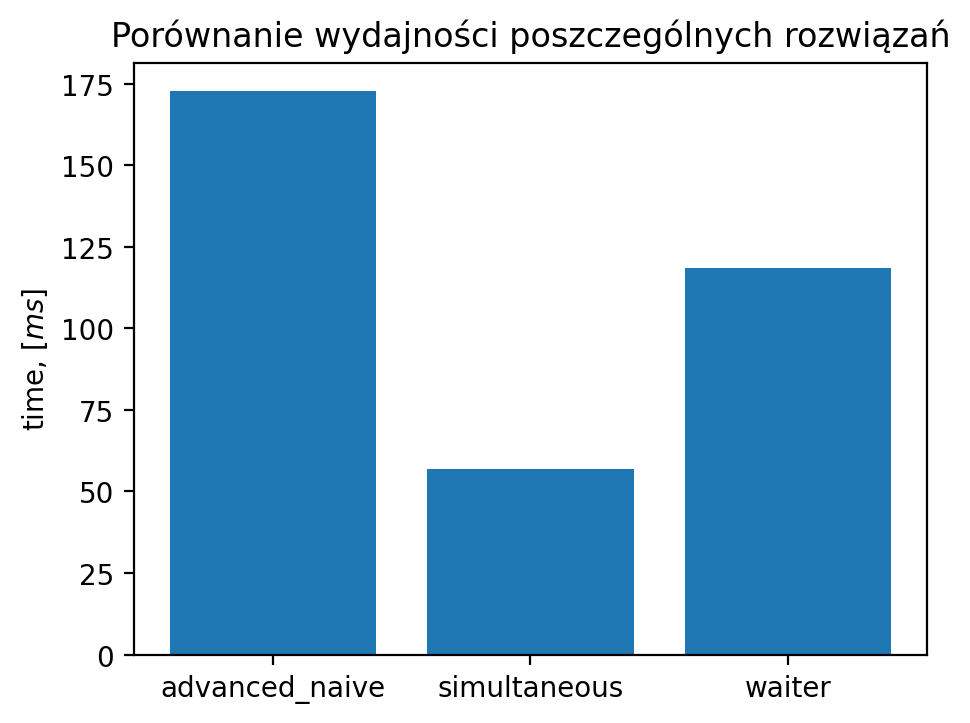

In [8]:
import matplotlib.pyplot as plt

names = ["advanced_naive", "simultaneous", "waiter"]
values = [advanced_naive, simultaneous, waiter]

defsize = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] =  (defsize[0] * 0.8, defsize[1] * 0.8)
plt.rcParams["figure.dpi"] = 200

plt.bar(names, values)
plt.title("Porównanie wydajności poszczególnych rozwiązań")
plt.ylabel("time, $[ms]$")
plt.show()

# Wnioski

- Jak widać z powyższego wykresu, najszybszą okazała się metoda **jednoczesnego podnoszenia widelców**. Nie
  jest to wcale zaskakujące, bo implementacja tego rozwiązania jest również bardzo prosta i wykorzystuje
  tylko 2 metody synchroniczne - do podnoszenia oraz odłożenia widelców, w których wartości dwóch semaforów
  zostają zmniejszone lub zwiększone.

- **Rozwiązanie z lokajem** jest ponad 2 razy wolniejsze od poprzedniego. W tym rozwiązaniu zostały wykorzystane
  różne mechanizmy wielowątkowości (kolejki blokujące, concurrent hash mapy, monitory oraz semafory) co ma pewien
  narzut wydajnościowy. Implementacja może zostać ulepszona w następujący sposób:

  - Rezygnacja z `ConcurrentHashMap`: korzystanie z tej struktury danych nie jest obowiązkowe, w celu
    przechowywania wykorzystanych widelców przez danego filozofa można korzystać z np. zwykłych tablic indeksując
    po indeksach filozofów albo skorzystać z mechanizmu dziedziczenia i zaimplementować klasę filozofa
    przechowującego wykorzystane widelce. W każdym razie, zgodnie z profilingiem, narzut korzystania z tej
    struktury danych jest stosunkowo nie duzy

  - Zostąpienie `ArrayBlockingQueue` własnym mechanizmem umożliwiającym pobranie kilku (dwóch) i dodanie kilku
    (dwóch) wartości jednocześnie (np. nieco zmodyfikowany `SemaphoreBuffer` z poprzedniego ćwiczenia). Zgodnie
    z profilingiem, to własnie `ArrayBlockingQueue#take` zajmuje ponad 50% czasu. Wywołując metodę `take` dwukrotnie,
    korzystamy z mechanizmów synchronizacji 2 razy więcej niż powinniśmy (to również dotyczy metod `add`/`addAll`)

    <!-- Relative path: export via web interface, not VSCode (as of 1.83.1) -->
    ![profiler](profiler.png)

- **Autorskie rozwiązanie**, zgodnie z oczekiwaniami, jest najmniej wydajne - głównie z powodu wprowadzonych
  dodatkowych oczekiwań.

- **Zakleszczenie (deadlock)** to sytuacja, w której procesy blokują się nawzajem z powodu zajęcia
  zasobów i żaden z procesów nie robi postępów, ponieważ czekają na zasób trzymany przez inny proces

- W przypadku **zakleszczenia dynamicznego (livelock)**, z jednej strony stany zaangażowanych procesów ciągle
  się zmieniają. Z drugiej strony, procesy nadal są od siebie zależne i nigdy nie mogą zakończyć swoich zadań.

- Podsumowując, zostały zaimplementowane 4 różne podejścia rozwiązujące problem pięciu filozofów, a mianowicie:

  1. **Naiwne podejście**, które może powodować zakleszczenia
  2. **Zaawansowane naiwne podejście** (*autorskie rozwiązanie*), stosujące mechanizm oparty ma oczekiwaniu pewnej
     ilości czasu, która jest obliczana w oparciu o indeks filozofa oraz numer próby
  3. **Widelce podnoszone jednocześnie**: rozwiązanie to jest wolne od blokady, jednak w przypadku, gdy zawsze któryś
     z sąsiadów będzie zajęty jedzeniem, nastąpi zagłodzenie, gdyż oba widelce nigdy nie będą wolne
  4. **Rozwiązanie z lokajem**: jest to najbardziej zaawansowane rozwiązanie z wyżej wymienionych, polegające na tym,
     że zewnętrzny arbiter pilnuje, aby jednocześnie co najwyżej $n-1$ filozofów konkurowało o widelce

- **Ranking** zaimplementowanych rozwiązań **według wydajności**:

  1. Widelce podnoszone jednocześnie
  2. Rozwiązanie z lokajem
  3. Zaawansowane naiwne podejście
  4. Naiwne podejście (występuje zakleszczenie)

# Bibliografia

1. Materiały do laboratorium, dr inż. Włodzimierz Funika:\
   [https://home.agh.edu.pl/~funika/tw/lab5/](https://home.agh.edu.pl/~funika/tw/lab5/)

2. Materiały do laboratorium, dr hab. inż. Bartosz Baliś\
   [https://home.agh.edu.pl/~balis/dydakt/tw/lab8/tw-5fil.pdf](https://home.agh.edu.pl/~balis/dydakt/tw/lab8/tw-5fil.pdf)

3. Problem ucztujących filozofów - Wikipedia:\
   [https://pl.wikipedia.org/wiki/Problem_ucztujących_filozofów](https://pl.wikipedia.org/wiki/Problem_ucztujących_filozofów)

4. Dining philosophers problem - Wikipedia:\
   [https://en.wikipedia.org/wiki/Dining_philosophers_problem](https://en.wikipedia.org/wiki/Dining_philosophers_problem)

5. Deadlock, Livelock and Starvation - Baeldung:\
   [https://www.baeldung.com/cs/deadlock-livelock-starvation](https://www.baeldung.com/cs/deadlock-livelock-starvation)

6. `Object` - Java 17 Docs:\
   [https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/lang/Object.html](https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/lang/Object.html)

7. `ArrayBlockingQueue` - Java 17 Docs:\
   [https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/ArrayBlockingQueue.html](https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/ArrayBlockingQueue.html)

8. `ConcurrentHashMap` - Java 17 Docs:\
   [https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/ConcurrentHashMap.html](https://docs.oracle.com/en/java/javase/17/docs/api/java.base/java/util/concurrent/ConcurrentHashMap.html)

9. Carrier Sense Multiple Access (CSMA) - GeeksForGeeks:\
   [https://www.geeksforgeeks.org/carrier-sense-multiple-access-csma/](https://www.geeksforgeeks.org/carrier-sense-multiple-access-csma/)

<!-- https://stackoverflow.com/a/69094533/9200394 -->